In [11]:
import pandas as pd

# Daten
Wir haben 2 Datensätze:
Einen für die Herzfrequenz pro Tag und einen für den Schlaf.


In [12]:
# Loading data
hr_df = pd.read_csv(r'..\..\data\Oliver\raw\raw_hr_hr.csv')

sleep_df = pd.read_csv(r'..\..\data\Oliver\raw\sleep.csv')

## Data Cleaning

### Herzfrequenz

### Schlaf



In [13]:
## Sleep data
sleep_df['to'] = pd.to_datetime(sleep_df['to'])

# Using 'to' column as date which the awake period corresponds to
sleep_df['sleep_date'] = sleep_df['to'].dt.date

# Duration from light, deep and rem sleep duration
sleep_df['total_sleep_s'] = (sleep_df['light (s)'] + sleep_df['deep (s)'] + sleep_df['rem (s)'])
# Duration in hours
sleep_df['total_sleep_h'] = (sleep_df['total_sleep_s'] / 3600).round(2)

sleep_df.rename(columns={'Average heart rate': 'avg_sleep_hr'}, inplace=True)

# Clean Sleep Data
sleep_data = sleep_df[['sleep_date', 'total_sleep_h', 'avg_sleep_hr']].copy()

sleep_data['next_day'] = sleep_data['sleep_date'] + pd.Timedelta(days=1)

sleep_data


sleep_date  total_sleep_h  avg_sleep_hr    next_day
0   2024-08-12           6.40            67  2024-08-13
1   2024-08-13           8.17            69  2024-08-14
2   2024-08-14           8.58            62  2024-08-15
3   2024-08-15           7.53            60  2024-08-16
4   2024-08-16           8.60            57  2024-08-17
..         ...            ...           ...         ...
56  2024-10-14           8.65            65  2024-10-15
57  2024-10-15           8.37            60  2024-10-16
58  2024-10-16           7.73            61  2024-10-17
59  2024-10-17           8.05            62  2024-10-18
60  2024-10-18           9.93            63  2024-10-19

[61 rows x 4 columns]

In [14]:
## Average heart rate

# Parsing for 'value' and 'duration' columns
def parse_hr_value(s: str):
    s = s.strip('[]') # Remove brackets
    values = s.split(',') # Split into multiple values

    clean_values = []
    # Clean every value
    for v in values:
        v_clean = v.strip().replace(' ', '').replace(',', '.')
        try:
            num = int(v_clean)
            clean_values.append(num)
        except ValueError:
            print(f"Found invalid value: '{v_clean}'")

    return clean_values



# Parsing for 'value' and 'duration' columns
hr_df['duration_list'] = hr_df['duration'].apply(parse_hr_value)
hr_df['value_list'] = hr_df['value'].apply(parse_hr_value)

# Explode multiple values into rows
hr_expanded = hr_df.explode(['duration_list', 'value_list'])

# Grouping by date
hr_expanded['start'] = pd.to_datetime(hr_expanded['start'])
hr_expanded['awake_date'] = hr_expanded['start'].dt.date

# Calculate average bpm of the day
hr_day_avg = hr_expanded.groupby('awake_date')['value_list'].mean().reset_index()
hr_day_avg.rename(columns={'value_list': 'avg_hr_day'}, inplace=True)

# Merging all relevant data
merged_data = pd.merge(sleep_data, hr_day_avg, left_on='next_day', right_on='awake_date', how='inner')

# Removing NaN and non numeric
merged_data = merged_data.dropna(subset=['total_sleep_h', 'avg_hr_day', 'avg_sleep_hr'])
merged_data['total_sleep_h'] = pd.to_numeric(merged_data['total_sleep_h'], errors='coerce')
merged_data['avg_hr_day'] = pd.to_numeric(merged_data['avg_hr_day'], errors='coerce')
merged_data['avg_sleep_hr'] = pd.to_numeric(merged_data['avg_sleep_hr'], errors='coerce')


# Visualize


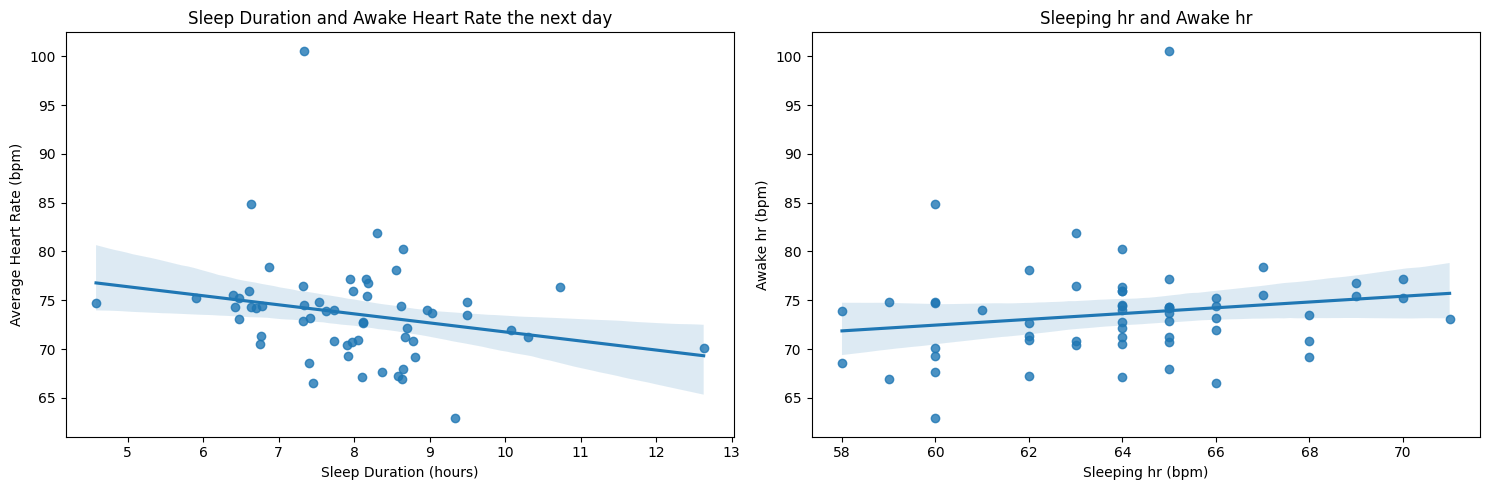

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting with Matplotlib / Seaborn
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# First Plot
sns.regplot(x='total_sleep_h', y='avg_hr_day', data=merged_data, ax=ax1, dropna=True)
ax1.set_title('Sleep Duration and Awake Heart Rate the next day')
ax1.set_xlabel('Sleep Duration (hours)')
ax1.set_ylabel('Average Heart Rate (bpm)')

# Second plot
sns.regplot(x='avg_sleep_hr', y='avg_hr_day', data=merged_data, ax=ax2, dropna=True)
ax2.set_title('Sleeping hr and Awake hr')
ax2.set_xlabel('Sleeping hr (bpm)')
ax2.set_ylabel('Awake hr (bpm)')


plt.tight_layout()
plt.show()


In [16]:
# Plotting with plot.ly
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm


# Create a subplot with 1 row and 2 columns
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=(
        "Sleep Duration and Awake Heart Rate the Next Day",
        "Sleeping Heart Rate and Awake Heart Rate"
    )
)

# Function to add scatter and regression line to a subplot
def add_regression_trace(fig, row, col, x, y, title, x_label, y_label, marker_color, line_color):
    # Add scatter trace
    fig.add_trace(
        go.Scatter(
            x=x,
            y=y,
            mode='markers',
            name='Data',
            marker=dict(color=marker_color)
        ),
        row=row, col=col
    )

    # Prepare data for regression (drop NaNs)
    df = pd.DataFrame({'x': x, 'y': y}).dropna()
    X = sm.add_constant(df['x'])  # Adds a constant term to the predictor
    model = sm.OLS(df['y'], X).fit()
    predictions = model.predict(X)

    # Add regression line trace
    fig.add_trace(
        go.Scatter(
            x=df['x'],
            y=predictions,
            mode='lines',
            name='Fit',
            line=dict(color=line_color)
        ),
        row=row, col=col
    )

    # Update axes titles
    fig.update_xaxes(title_text=x_label, row=row, col=col)
    fig.update_yaxes(title_text=y_label, row=row, col=col)

# First Plot: Sleep Duration vs. Awake Heart Rate
add_regression_trace(
    fig=fig,
    row=1,
    col=1,
    x=merged_data['total_sleep_h'],
    y=merged_data['avg_hr_day'],
    title="Sleep Duration and Awake Heart Rate the Next Day",
    x_label="Sleep Duration (hours)",
    y_label="Average Heart Rate (bpm)",
    marker_color='blue',
    line_color='red'
)

# Second Plot: Sleeping HR vs. Awake HR
add_regression_trace(
    fig=fig,
    row=1,
    col=2,
    x=merged_data['avg_sleep_hr'],
    y=merged_data['avg_hr_day'],
    title="Sleeping Heart Rate and Awake Heart Rate",
    x_label="Sleeping Heart Rate (bpm)",
    y_label="Awake Heart Rate (bpm)",
    marker_color='green',
    line_color='orange'
)

# Update overall layout
fig.update_layout(
    height=600,
    width=1200,
    title_text="Sleep and Heart Rate Analysis",
    showlegend=False  # Hide legend
)


fig.show()


# Analysis

In [17]:
# correlation of sleep duration and Avg Heart rate the next day
corr_sleep_d__awake_hr = merged_data['total_sleep_h'].corr(merged_data['avg_hr_day'])

# correlation of avg sleep hr and awake hr
corr_sleep_hr__awake_hr = merged_data['avg_sleep_hr'].corr(merged_data['avg_hr_day'])

print(f'Correlation of Sleep duration and Avg Heart Rate the next day is:\n {corr_sleep_d__awake_hr}')

print(f'Correlation of avg sleep Heart Rate and avg Awake Heart Rate is:\n {corr_sleep_hr__awake_hr}')


Correlation of Sleep duration and Avg Heart Rate the next day is:
 -0.22443039766661185
Correlation of avg sleep Heart Rate and avg Awake Heart Rate is:
 0.17074437211497479
